In [1]:
# ---- Necessary Imports ---- 
import operator
from typing import TypedDict, Annotated, List
from langchain_ollama import OllamaLLM
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph import StateGraph, END


In [3]:
# ---- Agent State ----

class AgentState(TypedDict):
    input: str      # Original question
    #allows automatic accumulation of steps during LangGraph execution.
    intermediate_steps: Annotated[List[str], operator.add]  # Execution logs
    response: str    # Final answer
    search_query: str  # Generated search terms
    search_results: str   # Web search results


In [4]:
# -----  Model Search and tool ----
llm = OllamaLLM(base_url="http://localhost:11434", model="llama3.2:1b" )
search_tool = DuckDuckGoSearchRun()

In [5]:
# ----- Logging helper-----------

def log_step(state: AgentState, message: str) -> AgentState:
    steps = state.get("intermediate_steps", [])
    if message not in steps:  # Prevent any duplicate, not just consecutive ones
        print(f"[STEP] {message}")
        return {**state, "intermediate_steps": steps + [message]}
    return state


In [6]:
# ---- Plan Step ----

def plan_search(state: AgentState):
    if state.get("search_query"):
        return state

    state = log_step(state, "Planning search query")

    prompt = (
        f"You are a web based AI agent. Your job is to extract a clear, specific, and Google-searchable query "
        f"from the following question:\n\n"
        f"\"{state['input']}\"\n\n"
        "Generate ONE well-formed search query. Avoid explanations or punctuation. Include keywords of different types if u find relevant. "
        "Output only the search query, no quotes or extra text."
        "Analyze the user question,If not needed to search then you can use your own knowledge to answer "
    )
    raw_query = llm.invoke(prompt).strip().split('\n')[0]
    query = raw_query.replace('"', '').strip()

    # Optionally log if the query is suspicious
    if len(query.split()) < 2 or not query[0].isalnum():
        state = log_step(state, f"Warning: Low-confidence search query generated: '{query}'")

    state = log_step(state, f"Generated search query: {query}")
    return {**state, "search_query": query}


In [7]:
# ----- Node: Execute search --------
def execute_search(state: AgentState):
    state = log_step(state, "Executing web search")
    query = state.get("search_query", "").strip()
    if not query:
        state = log_step(state, "No search query found. Skipping search.")
        return {**state, "search_results": ""}
    try:
        results = search_tool.run(query)
        state = log_step(state, f"Obtained search results (truncated): {results[:200]}...")
        return {**state, "search_results": results}
    except Exception as e:
        state = log_step(state, f"Search failed: {str(e)}")
        return {**state, "search_results": ""}


In [8]:

# ----- Node: Generate final answer  -----
def generate_answer(state: AgentState):
    state = log_step(state, "Synthesizing final answer")
    prompt = (
        f"Based on these search results, answer the question: {state['input']}\n\n"
        f"{state.get('search_results', '')}"
    )
    answer = llm.invoke(prompt).strip()
    state = log_step(state, "Final answer generated.")
    return {**state, "response": answer}

In [9]:
# ---- Build the LangGraph workflow -----
workflow = StateGraph(AgentState)
workflow.add_node("plan", plan_search)
workflow.add_node("search", execute_search)
workflow.add_node("answer", generate_answer)

workflow.set_entry_point("plan")
workflow.add_edge("plan", "search")
workflow.add_edge("search", "answer")
workflow.add_edge("answer", END)

agent = workflow.compile()

In [10]:
# ---- Launch Gradio UI ----

import gradio as gr

def gradio_interface(user_input, history):
    state = {
        "input": user_input,
        "intermediate_steps": [],
        "response": "",
        "search_query": "",
        "search_results": ""
    }

    result = agent.invoke(state)

    # Deduplicate intermediate steps
    seen = set()
    deduped_steps = []
    for step in result["intermediate_steps"]:
        if step not in seen:
            deduped_steps.append(step)
            seen.add(step)

    steps_summary = "\n".join(f"- {step}" for step in deduped_steps)
    full_response = result["response"]

    # Update chat history
    history.append((f"🧑‍💻 {user_input}", f"🤖 {full_response}"))
    return "", history, f"**Steps Taken:**\n{steps_summary}"

if __name__ == "__main__":
    with gr.Blocks() as demo:
        gr.Markdown("# 🤖 AI Web Search Assistant")
        gr.Markdown("Ask anything and see how the AI finds the answer using live web search.")

        chatbot = gr.Chatbot(label="🧠 Chat History")

        with gr.Row():
            txt = gr.Textbox(show_label=False, placeholder="Ask me something...", scale=8)
            ask_btn = gr.Button("🔍 Ask", scale=1)

        with gr.Accordion("Show Summary of Steps", open=False):
            steps_box = gr.Markdown("")

        clear_btn = gr.Button("🧹 Clear Chat")

        # Wire button and text submission
        ask_btn.click(fn=gradio_interface, inputs=[txt, chatbot], outputs=[txt, chatbot, steps_box])
        txt.submit(fn=gradio_interface, inputs=[txt, chatbot], outputs=[txt, chatbot, steps_box])

        # Clear chat functionality
        clear_btn.click(fn=lambda: ("", [], ""), inputs=[], outputs=[txt, chatbot, steps_box])

    demo.launch(share=True)


C:\Users\Dell\AppData\Local\Temp\ipykernel_12016\2424821238.py:36: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="🧠 Chat History")


* Running on local URL:  http://127.0.0.1:7885
* Running on public URL: https://ef563762e1f507af73.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


[STEP] Planning search query
[STEP] Generated search query: I'm looking for a greeting
[STEP] Executing web search
[STEP] Obtained search results (truncated): e. Greet in a foreign language - Switch it up by greeting in a foreign language, and be classy! It is time to give the traditional greetings and conversations a rest! Instead, take a look at these ide...
[STEP] Synthesizing final answer
[STEP] Final answer generated.
[STEP] Planning search query
[STEP] Generated search query: india news
[STEP] Executing web search
[STEP] Obtained search results (truncated): India's foreign secretary also held a news conference and described the gun attack by "terrorists" in Indian-controlled Kashmir last month as the "original escalation". India carries out emergency rea...
[STEP] Synthesizing final answer
[STEP] Final answer generated.
[STEP] Planning search query
[STEP] Generated search query: 5 points news India today
[STEP] Executing web search
[STEP] Obtained search results (truncated): In t

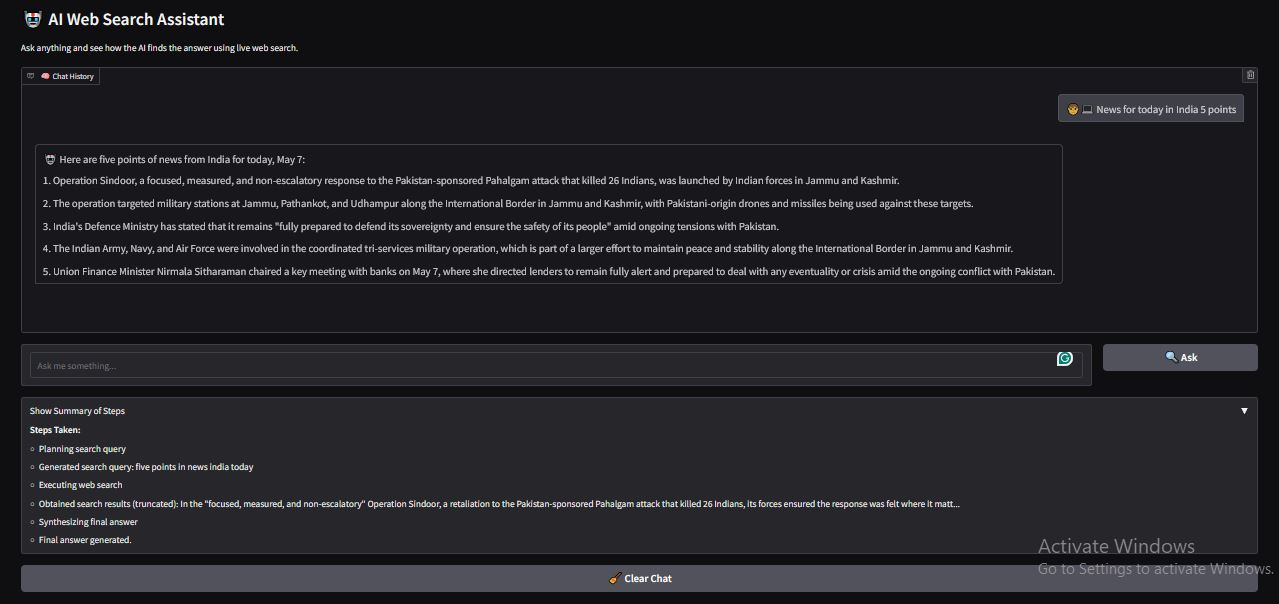

In [13]:
from IPython.display import Image, display

display(Image(filename=r'C:\Users\Dell\Downloads\Ui_image.jpg'))
